<a href="https://colab.research.google.com/github/PratyushJha254/Feature-Based-Dynamic-Pricing-Paper-Implementation-Cohen-et-al.-2020-/blob/main/EXP4_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numba import jit
import math

In [2]:
seed = 11
np.random.seed(seed)
R = 1

In [3]:
# @jit(nopython = True)
def plott(regret, T, minD = 0, maxD = 0, fst = True):
  if(fst):
    plt.plot(np.log(np.linspace(1,T,T)), regret)
  else:
    plt.plot(np.linspace(minD,maxD-1, maxD-minD), regret)

In [4]:
import numpy as np

def find_closest_array(A, B):
    # Initialize minimum distance and the index of the closest array
    min_dist = np.inf
    closest_array = None
    i=0
    # Iterate through each array in A
    for array in A:
        # Calculate the Euclidean distance from the current array to B
        dist = np.linalg.norm(np.array(array) - np.array(B))

        # If this distance is less than the current minimum, update min_dist and closest_array
        if dist < min_dist:
            min_dist = dist
            closest_array = i
        i+=1

    return closest_array

## Comparing Our Algorithm to a Benchmark from the Literature (EXP4)

## EXP4

In [5]:
# @jit(nopython=True)
def discretize_vector(d, gamma):
    # Generate a grid of equally spaced values in each dimension
    intervals = np.arange(0, 1, gamma)

    # Generate all combinations of values in each dimension
    grid = np.meshgrid(*[intervals]*d, indexing='ij')

    # Combine the values in each dimension to form vectors
    discretized_vectors = np.vstack([component.flatten() for component in grid]).T

    return discretized_vectors


In [6]:
@jit(nopython=True)
def weighted_choice(weights):
    cumulative_sum = np.cumsum(weights)
    rnd = np.random.rand() * cumulative_sum[-1]
    return np.searchsorted(cumulative_sum, rnd)

In [7]:
from numba import jit

@jit(nopython=True)
def EXP4(theta, d, gamma, eta, T,theta_dis, closest_pi):
    size = len(theta_dis)
    w0 = np.ones(size)  # Initialize weights uniformly
    pol_at = np.zeros(size)
    rt_pi = np.zeros(size)
    regret = np.zeros(T)
    rew_prev = 0
    rewards_prev = np.zeros(size)
    exp_reg = np.zeros(T)
    rew_store = np.zeros(size)
    # act_wt = np.zeros(1/(gamma*np.sqrt(d)))
    exp_val = 0
    maxi = 0
    for t in range(T):
        xt = np.abs(np.random.uniform(0, 1, d))  # Generate random vector xt
        xt = xt / np.sqrt(np.sum(xt ** 2))
        v = np.dot(theta, xt)  # Compute inner product of theta and xt
        gd = gamma * np.sqrt(d)
        # Discretize the inner product between theta and xt
        dis_thetax = gd * np.floor(np.dot(theta_dis, xt) / gd)

        # Compute the potential actions based on discretization
        pol_at = dis_thetax - gd ################################
        # pol_at = dis_thetax

        # Choose an action based on the weights w0
        probabilities = w0 / np.sum(w0)
        th_choice = weighted_choice(probabilities)
        at = pol_at[th_choice]

        # Compute reward
        # rt_at = at * (at <= v)
        rt_at = (at <= v)

        # Compute reward estimates for all actions
        sum_weights = 0
        for j in range(size):
          if (pol_at[j]==at):
            sum_weights += w0[j]

        for i in range(size):
            if pol_at[i] == at:
                # Compute sum of weights for actions where pol_at[j] == at using a list comprehension
                rt_pi[i] = (rt_at * np.sum(w0)) / sum_weights
            else:
                rt_pi[i] = 0

        prev_m = max(rew_store)

        # Update weights
        # if(rt_at!=0):
        for j in range(size):
          w0[j] = w0[j]*np.exp(eta * (rt_pi[j]))


        act_wts = {}
        for i in range (size):
          actions = pol_at[i]
          rew_store[i] += (actions<=v)
          if actions in act_wts:
            act_wts[actions] += w0[i]
          else:
            act_wts[actions] = w0[i]
        maxi = max(maxi,len(act_wts))

        # print(len(act_wts))
        total_wt = np.sum(w0)
        for x in act_wts: ####
          rt_act = (x<=v)
          exp_val += (rt_act*(act_wts[x]))/total_wt



        exp_reg[t] =  max(rew_store)-exp_val
        # rt_at = at*(at<=v)
        regret[t] += regret[max(0,t-1)] + (1-rt_at)

        if((t+1)%1000==0):
            print('t=', t)
            print('Selected Price:', at)
            print('Actual Price:', v)
            # print("th_choice'xt", np.dot(th_choice,xt))
            print('Regret:', exp_reg[t])
            print('Selected Policy', theta_dis[th_choice])

            print('Correct Policy', theta)
            print('Selected Policy Weights', w0[th_choice])
            print('Correct Policy Weights', w0[closest_pi])
            print('--------------------------')
    print(maxi)

    return exp_reg, w0,regret


Exploring for the best learning rate (eta)

In [8]:
# T = 60000
# d = 2
# gamma = 1 / ((T*np.sqrt(d)) ** (1/3))
# theta = np.abs(np.random.uniform(0, 1, d))
# theta = theta / np.sqrt(np.sum(theta ** 2))
# theta_dis = discretize_vector(d, gamma)
# # theta_dis = np.array([x for x in theta_dis if np.sqrt(np.sum(x**2))<=1])
# size = len(theta_dis)
# eta = np.sqrt(2* np.log(size) / (T * (1/(gamma*np.sqrt(d)))))


In [9]:
# T = 20000
# d = 2
# gamma = 1 / ((T*np.sqrt(d)) ** (1/3))
# theta = np.abs(np.random.uniform(0, 1, d))
# theta = theta / np.sqrt(np.sum(theta ** 2))
# theta_dis = discretize_vector(d, gamma)
# # theta_dis = np.array([x for x in theta_dis if np.sqrt(np.sum(x**2))<=1])
# size = len(theta_dis)
# eta = np.sqrt(2* np.log(size) / (T * (1/(gamma*np.sqrt(d)))))
# etas = [eta/2, eta/3, eta/4, eta/5]

# nums=2
# for i in etas:
#   regret, w0,reggi = EXP4(theta, d, gamma, i, T,theta_dis)
#   # eta = eta/3
#   plt.plot(np.log(range(0,T)), regret, label = nums)
#   plt.legend()
#   nums+=1

d = 2

In [10]:
d = 2
T = 100000
gamma = 1 / ((T*np.sqrt(d)) ** (1/3))
theta = np.abs(np.random.uniform(0, 1, d))
theta = theta / np.sqrt(np.sum(theta ** 2))
theta_dis = discretize_vector(d, gamma)
size = len(theta_dis)
eta = np.sqrt(2* np.log(size) / (T * (1/(gamma*np.sqrt(d)))))/2

t= 999
Selected Price: 0.5428835233189815
Actual Price: 0.9624791011435577
Regret: 340.0337139029151
Selected Policy [0.47984578 0.38387662]
Correct Policy [0.99421493 0.10740894]
Selected Policy Weights 2.7935432085518617
Correct Policy Weights 2.376957380839868
--------------------------
t= 1999
Selected Price: 0.5971718756508797
Actual Price: 0.4046277135605421
Regret: 590.3861249583322
Selected Policy [0.01919383 0.67178409]
Correct Policy [0.99421493 0.10740894]
Selected Policy Weights 5.847675817887623
Correct Policy Weights 6.325043624028592
--------------------------
t= 2999
Selected Price: 0.32573011399138896
Actual Price: 0.7647096173023286
Regret: 777.6935259776556
Selected Policy [0.07677532 0.42226428]
Correct Policy [0.99421493 0.10740894]
Selected Policy Weights 14.133418367726165
Correct Policy Weights 15.147406325245457
--------------------------
t= 3999
Selected Price: 0.2714417616594908
Actual Price: 0.3473340459703294
Regret: 922.1558674590297
Selected Policy [0.479

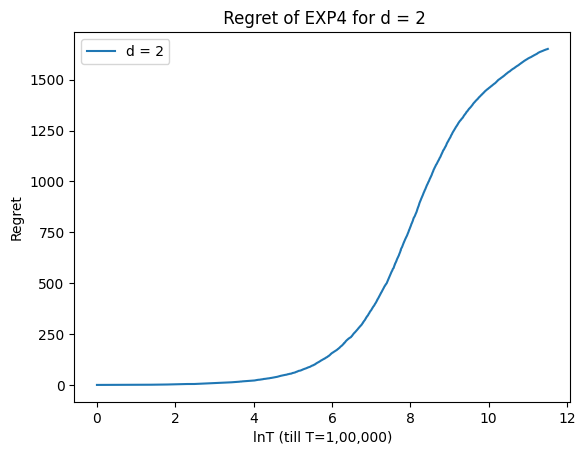

In [11]:
closest_pi = find_closest_array(theta_dis, theta)
regret2, w0,reggi = EXP4(theta, d, gamma, eta, T,theta_dis, closest_pi)
plt.plot(np.log(range(1,T+1)),regret2, label='d = '+str(2))
# plt.plot(np.log(range(1,T+1)),regret3, label=3)
plt.xlabel('lnT (till T=1,00,000)')
plt.ylabel('Regret')
plt.title(' Regret of EXP4 for d = 2')
plt.legend()

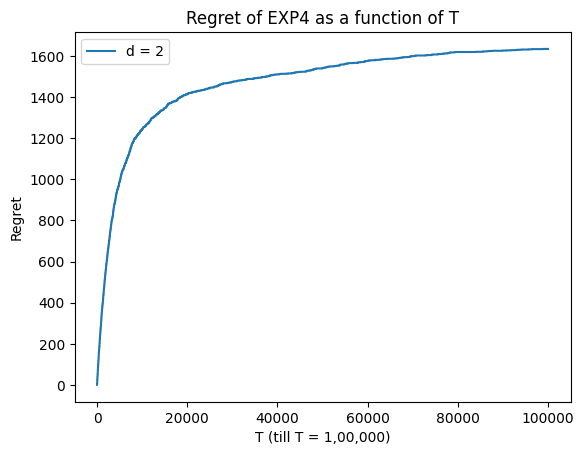

In [12]:
plt.plot(range(1,T+1), reggi, label = 'd = '+str(2))
plt.xlabel('T (till T = 1,00,000)')
plt.ylabel('Regret')
plt.title('Regret of EXP4 as a function of T')
plt.legend()

The last two cells show the policy weights and the original theta value.

d = 3

In [ ]:
d = 3
T = 10000
gamma = 1 / ((T*np.sqrt(d)) ** (1/3))
theta = np.abs(np.random.uniform(0, 1, d))
theta = theta / np.sqrt(np.sum(theta ** 2))
theta_dis = discretize_vector(d, gamma)
# theta_dis = np.array([x for x in theta_dis if np.sqrt(np.sum(x**2))<=1])
closest_pi = find_closest_array(theta_dis, theta)
size = len(theta_dis)
eta = np.sqrt(2* np.log(size) / (T * (1/(gamma*np.sqrt(d)))))/2


In [ ]:
regret3, w0,reggi = EXP4(theta, d, gamma, eta, T,theta_dis, closest_pi)

t= 999
Selected Price: 0.5355463600657357
Actual Price: 0.757167563054632
Regret: 103.05490535925242
Selected Policy [0.15459892 0.42514702 0.54109621]
Correct Policy [0.48381465 0.75716673 0.43888715]
Selected Policy Weights 495.5123048559981
Correct Policy Weights 155.07301134671215
--------------------------
t= 1999
Selected Price: 0.40165977004930187
Actual Price: 0.6632369668064456
Regret: 127.03703591406088
Selected Policy [0.46379675 0.15459892 0.42514702]
Correct Policy [0.48381465 0.75716673 0.43888715]
Selected Policy Weights 499766.7071967294
Correct Policy Weights 43656.21895373243
--------------------------
t= 2999
Selected Price: 0.40165977004930187
Actual Price: 0.8602127985617544
Regret: 141.1408770567691
Selected Policy [0.46379675 0.50244648 0.07729946]
Correct Policy [0.48381465 0.75716673 0.43888715]
Selected Policy Weights 66942839.84215739
Correct Policy Weights 25666217.830007434
--------------------------
t= 3999
Selected Price: 0.2677731800328679
Actual Price: 

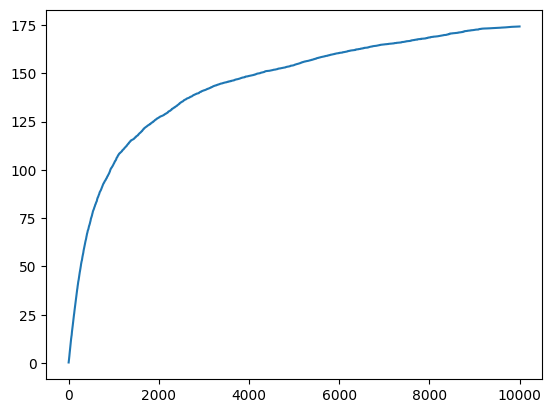

In [ ]:
plt.plot((range(1,T+1)),regret3, label=3)

In [ ]:
# plt.plot(np.log(range(1,T+1)),regret4, label="d=4")
plt.plot(np.log(range(1,T+1)),regret3, label="d=3")
plt.plot(np.log(range(1,T+1)),regret2, label="d=2")
plt.legend()

d = 4

In [ ]:
d = 4
T = 10000
gamma = 1 / ((T*np.sqrt(d)) ** (1/3))
theta = np.abs(np.random.uniform(0, 1, d))
theta = theta / np.sqrt(np.sum(theta ** 2))
theta_dis = discretize_vector(d, gamma)
# theta_dis = np.array([x for x in theta_dis if np.sqrt(np.sum(x**2))<=1])
closest_pi = find_closest_array(theta_dis, theta)
size = len(theta_dis)
eta = np.sqrt(2* np.log(size) / (T * (1/(gamma*np.sqrt(d)))))/2

In [ ]:
regret4, w0,reggi = EXP4(theta, d, gamma, eta, T,theta_dis, closest_pi)

In [ ]:
plt.plot(np.log(range(1,T+1)),regret4, label="d=4")

In [ ]:
plt.plot(np.log(range(1,T+1)),reggi, label=2)

In [ ]:
plt.plot((range(1,T+1)),reggi, label=2)

Top n highest weighted policies

In [13]:
def print_top_n_largest(array, n, theta_dis):
    top_n_indices = np.argpartition(array, -n)[-n:]  # Indices of the top N largest values
    top_n_values = array[top_n_indices]  # Corresponding values
    sorted_indices = top_n_indices[np.argsort(top_n_values)][::-1]  # Sort indices based on values
    sorted_values = top_n_values[np.argsort(top_n_values)][::-1]  # Sort values in descending order

    print(f"Top {n} largest values and their indices:")
    for value, index in zip(sorted_values, sorted_indices):
        print(f"Value: {value}, Index: {index}, theta: {theta_dis[index]}")


array = w0#/np.sqrt(np.sum(w0**2))  # Example array of 100 random values
print_top_n_largest(array,20,theta_dis)

Top 20 largest values and their indices:
Value: 1.48737174973776e+47, Index: 637, theta: [0.23032597 0.01919383]
Value: 7.513442080589391e+46, Index: 2550, theta: [0.92130389 0.11516299]
Value: 7.107853338368627e+46, Index: 2706, theta: [0.97888538 0.05758149]
Value: 6.466899878957006e+46, Index: 1326, theta: [0.47984578 0.01919383]
Value: 6.449655023456615e+46, Index: 265, theta: [0.09596916 0.        ]
Value: 6.103831030832826e+46, Index: 746, theta: [0.26871363 0.07677532]
Value: 5.270439754396388e+46, Index: 160, theta: [0.05758149 0.01919383]
Value: 5.185706479139499e+46, Index: 2603, theta: [0.94049772 0.11516299]
Value: 4.882740833362698e+46, Index: 795, theta: [0.28790747 0.        ]
Value: 4.705243420432072e+46, Index: 376, theta: [0.13435682 0.09596916]
Value: 4.699247009900487e+46, Index: 2654, theta: [0.95969155 0.07677532]
Value: 4.3854477410168576e+46, Index: 1274, theta: [0.46065194 0.03838766]
Value: 4.310156118328028e+46, Index: 213, theta: [0.07677532 0.01919383]
Valu

Original theta

In [14]:
print('theta:',theta)

theta: [0.99421493 0.10740894]
